In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [4]:
#load data
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'



In [5]:
#Check Class Distribution

def count_images(directory):
    for label in ['NORMAL', 'PNEUMONIA']:
        count = len(os.listdir(os.path.join(directory, label)))
        print(f'{label}: {count} images')

print("Training data:")
count_images(train_dir)

print("\nValidation data:")
count_images(val_dir)

print("\nTesting data:")
count_images(test_dir)


Training data:
NORMAL: 1341 images
PNEUMONIA: 3875 images

Validation data:
NORMAL: 8 images
PNEUMONIA: 8 images

Testing data:
NORMAL: 227 images
PNEUMONIA: 390 images


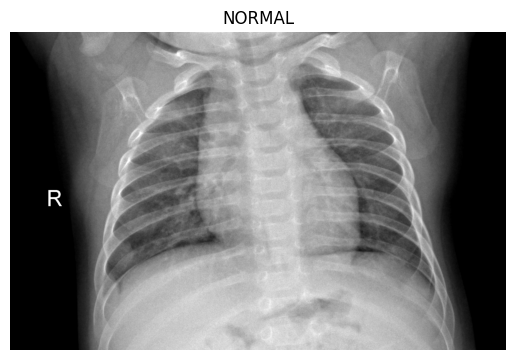

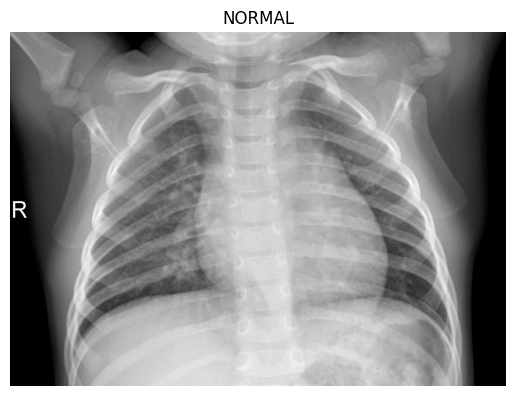

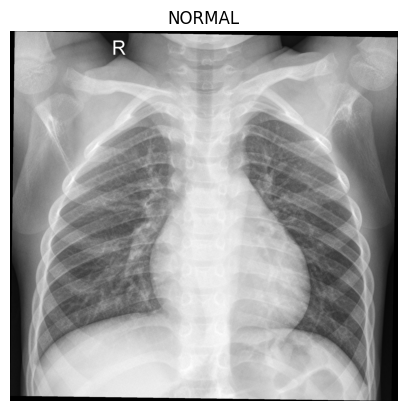

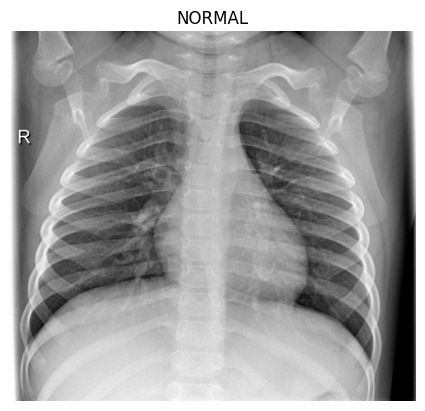

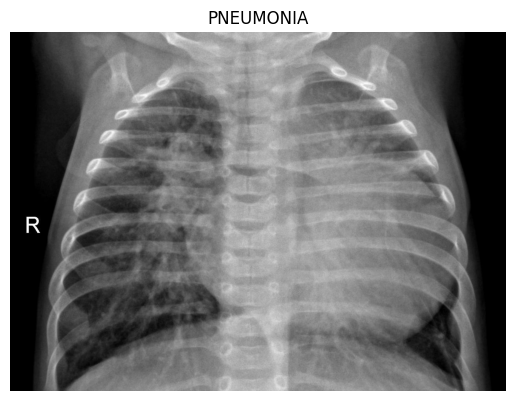

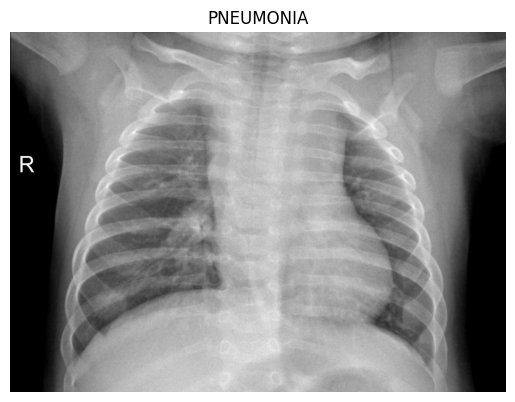

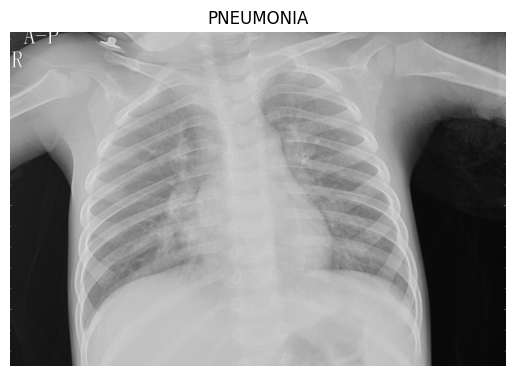

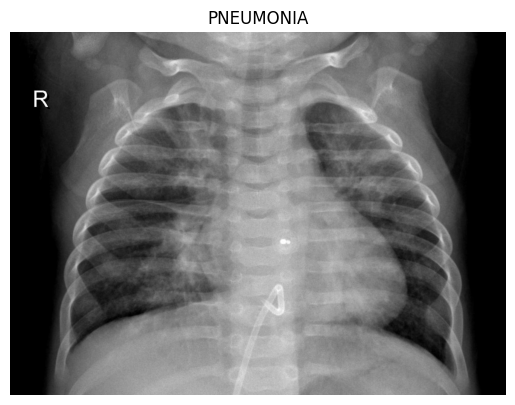

In [6]:
#Visualize Sample Images

def show_random_images(folder, label, n=4):
    files = os.listdir(os.path.join(folder, label))
    samples = random.sample(files, n)
    for img_file in samples:
        img_path = os.path.join(folder, label, img_file)
        img = Image.open(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
        plt.show()

show_random_images(train_dir, 'NORMAL')
show_random_images(train_dir, 'PNEUMONIA')


In [7]:
# Image size and batch size
img_size = 150
batch_size = 32

# 1. Define a training generator with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1,  # 10% of training data used for validation
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

# 2. Use 'subset' to separate training and validation data
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',  # 90% for training
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',  # 10% for validation
    shuffle=False
)

# 3. Test generator stays the same
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 4695 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 617 images belonging to 2 classes.


In [8]:
#CNN

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\kassi\Desktop\Disease detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Transfer Learning

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_tl = Model(inputs=base_model.input, outputs=predictions)

model_tl.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_tl.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
#train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


c:\Users\kassi\Desktop\Disease detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 72s 478ms/step - accuracy: 0.7323 - loss: 0.6384 - val_accuracy: 0.8330 - val_loss: 0.3950
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 71s 483ms/step - accuracy: 0.8591 - loss: 0.3214 - val_accuracy: 0.8138 - val_loss: 0.3949
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8823 - loss: 0.2891 - val_accuracy: 0.8522 - val_loss: 0.3368
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9066 - loss: 0.2496 - val_accuracy: 0.8906 - val_loss: 0.2586
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.9079 - loss: 0.2189 - val_accuracy: 0.8887 - val_loss: 0.2464
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9066 - loss: 0.2139 - val_accuracy: 0.8906 - val_loss: 0.2450
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 132s 896ms/step - accuracy: 0.9254 - loss: 0.1838 - val_accuracy: 0.8983 - val_loss: 0.2264
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 76s 515ms/step - accuracy: 0.9318 - loss: 0.1900 -

In [15]:
# Fine-tune — unfreeze part of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune training
fine_tune_history = model.fit(train_gen,
                              validation_data=val_gen,
                              epochs=5)  # additional epochs

Epoch 1/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 82s 549ms/step - accuracy: 0.9361 - loss: 0.1579 - val_accuracy: 0.9328 - val_loss: 0.1691
Epoch 2/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 77s 526ms/step - accuracy: 0.9425 - loss: 0.1524 - val_accuracy: 0.9271 - val_loss: 0.1876
Epoch 3/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 78s 534ms/step - accuracy: 0.9447 - loss: 0.1459 - val_accuracy: 0.9309 - val_loss: 0.1733
Epoch 4/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.9556 - loss: 0.1314 - val_accuracy: 0.9271 - val_loss: 0.1780
Epoch 5/5
147/147 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9489 - loss: 0.1417 - val_accuracy: 0.9232 - val_loss: 0.1996


In [16]:
#Evaluate it on the test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 510ms/step - accuracy: 0.8241 - loss: 0.4944
Test Accuracy: 0.88


In [17]:
# Predict on test set
pred_probs = model.predict(test_gen)
pred_classes = (pred_probs > 0.5).astype("int32")  # Convert probabilities to 0 or 1

# True labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

# Classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 487ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.73      0.82       227
   PNEUMONIA       0.86      0.97      0.91       390

    accuracy                           0.88       617
   macro avg       0.90      0.85      0.87       617
weighted avg       0.89      0.88      0.88       617



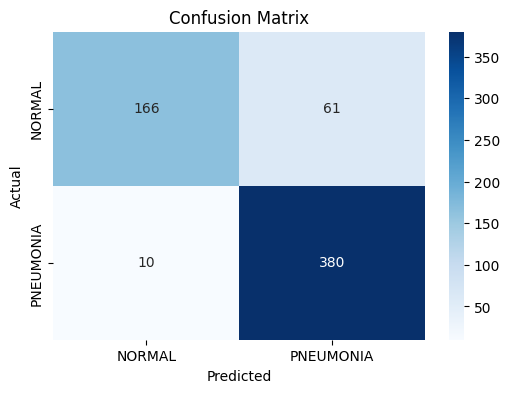

In [23]:
#Confusion Matrix

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


1. True Positives (TP) = 380
These are pneumonia cases that were correctly predicted as pneumonia.

2. True Negatives (TN) = 166
These are normal cases correctly predicted as normal.

3. False Positives (FP) = 61
These are normal cases wrongly predicted as pneumonia.

4. False Negatives (FN) = 10
These are pneumonia cases wrongly predicted as normal.


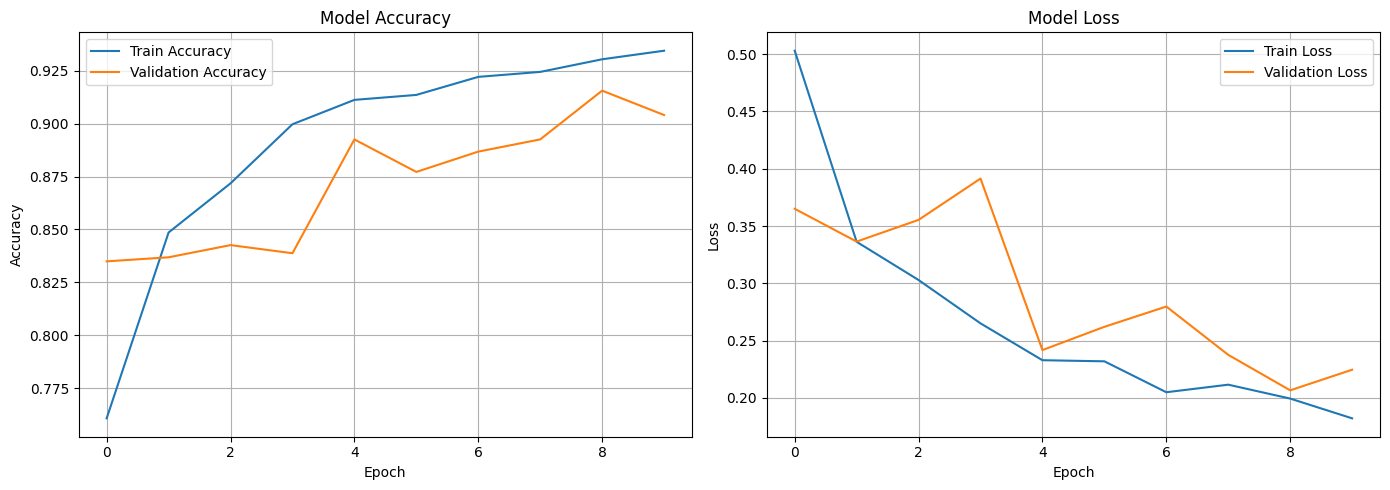

In [49]:

# Accuracy Curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


The model achieved:

Training Accuracy: ~93.5%

Validation Accuracy: ~91%

Training Loss: ~0.18

Validation Loss: ~0.22

The training and validation curves were smooth and closely aligned, with no significant overfitting.

This method was quick and effective, but slightly limited due to random splitting and no fine-tuning.

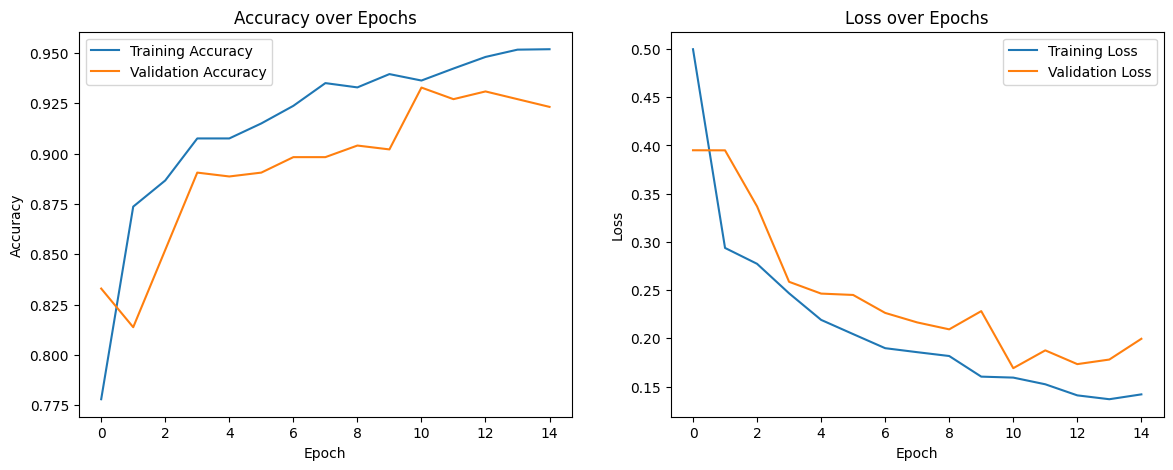

In [ ]:
# Combine histories
# visualize improvement over all epochs (before + after fine-tuning):
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

# Plot
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


The model achieved:

Training Accuracy: ~95.5%

Validation Accuracy: ~93%

Training Loss: ~0.13

Validation Loss: ~0.20

The model showed stronger generalization, with only a slight increase in validation loss in later epochs.

Fine-tuning clearly improved the model’s feature learning and final performance.

conclusion:
-Overfitting was a major issue in the initial training phase.

-Introducing a validation split helped stabilize training and improve performance.

-Fine-tuning with a manually controlled validation set led to the best model, with excellent generalization and high accuracy.